# Libraries and Dependencies

In [2]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def apply_gamma_correction(img, gamma):
  lookUpTable = np.empty((1,256), np.uint8)
  for i in range(256):
      lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
  return cv.LUT(img, lookUpTable)

### Normalization of Metrics:

$$\text{area\_score} = \min \left( \max \left( \frac{\text{area} - 100}{900}, 0 \right), 1 \right)$$

$$
\text{circularity\_score} = \min \left( \max \left( \frac{\text{circularity} - 0.48}{0.52}, 0 \right), 1 \right)
$$

$$
\text{white\_percentage\_score} = \min \left( \max \left( \frac{\text{white\_percentage} - 0.05}{0.95}, 0 \right), 1 \right)
$$

### Weighted Average Calculation:

$$
\text{score} = 0.25 \times \text{area\_score} + 0.5 \times \text{circularity\_score} + 0.25 \times \text{white\_percentage\_score}
$$


In [4]:
def calculate_score(area, circularity, white_percentage):
    area_score = min(max((area - 100) / (1000 - 100), 0), 1) 
    circularity_score = min(max((circularity - 0.48) / (1 - 0.48), 0), 1) 
    white_percentage_score = min(max((white_percentage - 0.05) / (1 - 0.05), 0), 1)  

    score = 0.15 * area_score + 0.7 * circularity_score + 0.15 * white_percentage_score
    return score

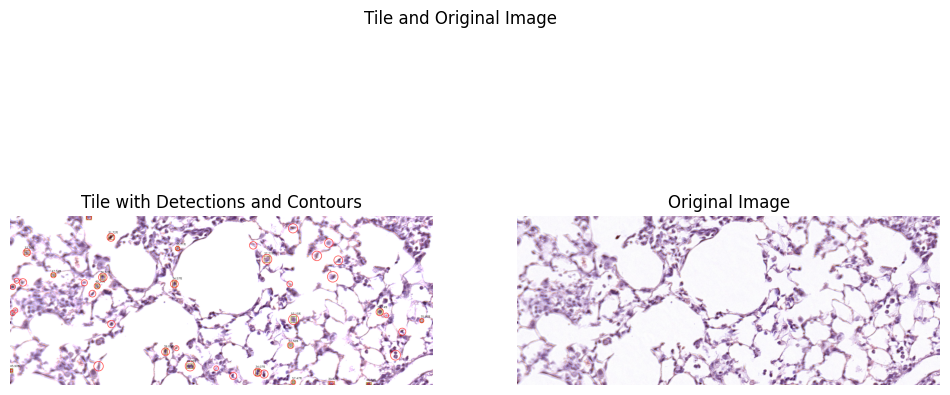

In [12]:
img_name = 'tile_25000_52000.jpg'
file_name = os.path.expanduser('~/Documents/Code/Lung_Injury/Tiles_1000_2500_1/' + img_name)
out_dir = os.path.expanduser('~/Documents/Code/Lung_Injury/' + img_name)

tile = cv2.imread(file_name)
image_intact = tile.copy()

tile[tile > 220] = 255
gray_tile = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(gray_tile, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

mask = np.zeros_like(gray_tile)
cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)

internal_mask = cv2.bitwise_not(mask)
internal_only = cv2.bitwise_and(thresh, thresh, mask=internal_mask)
internal_contours, _ = cv2.findContours(internal_only, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# cv2.drawContours(tile, contours, -1, (255, 0, 0), 2)

for contour in contours:
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if perimeter == 0:
        continue

    circularity = 4 * np.pi * (area / (perimeter * perimeter))

    if 150 < area < 900 and 0.40 < circularity < 1:
        x, y, w, h = cv2.boundingRect(contour)

        k = 1.05
        padding = int(k * np.sqrt(area))

        center_x = x + w // 2
        center_y = y + h // 2

        radius = padding
        radius = min(radius, center_x, center_y, tile.shape[1] - center_x, tile.shape[0] - center_y)

        neighborhood_mask = np.zeros_like(thresh, dtype=np.uint8)
        cv2.circle(neighborhood_mask, (center_x, center_y), radius, 255, thickness=-1)

        neighborhood = cv2.bitwise_and(thresh, thresh, mask=neighborhood_mask)

        cv2.circle(tile, (center_x, center_y), radius, (0, 0, 255), 2)  


        total_pixels = cv2.countNonZero(neighborhood_mask)
        white_pixels = cv2.countNonZero(neighborhood)
        white_percentage = white_pixels / total_pixels

        if white_percentage > 0.08:
            score = calculate_score(area, circularity, white_percentage)
            
            if score < 0.3:
                continue
            red = int(255 * (1 - score))
            green = int(255 * score)
            color = (0, green, red)

            cv2.rectangle(tile, (x, y), (x + w, y + h), color, 2)

            score_text = f"{score * 100:.2f}%"
            text_position = (x, y - 10)
            cv2.putText(tile, score_text, text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

cv2.imwrite(out_dir, tile)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv2.cvtColor(tile, cv2.COLOR_BGR2RGB))
axes[0].set_title("Tile with Detections and Contours")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(image_intact, cv2.COLOR_BGR2RGB))
axes[1].set_title("Original Image")
axes[1].axis('off')

plt.suptitle("Tile and Original Image")
plt.show()